# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [1]:
import os
import h5py
import numpy as np

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot, plot_SO3_space
from IPython.display import Image
from cryoem.angle_recovery import train_angle_recovery

import tensorflow as tf
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays
from cryoem.angle_recovery import geodesic_distance, update_angles, distance_difference, find_best_rotation
from cryoem.distance_estimation import train_siamese

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7021663602640540640
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14260085332254035064
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15510161880746323731
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15810871415617764444
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 555898800475747320
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory

In [3]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [4]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


### True Angles

In [5]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

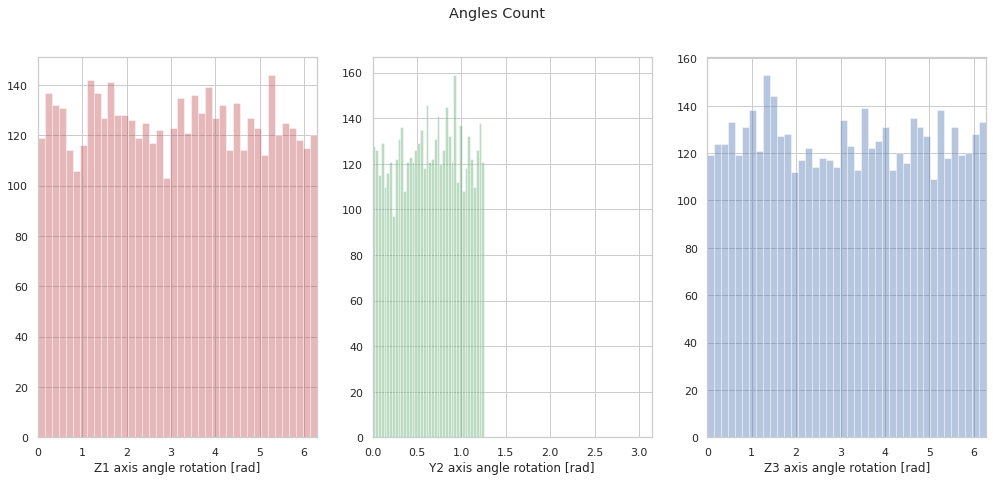

In [6]:
plot_angles_count(angles_true)

---

## Prepare for training

In [13]:
from sklearn.model_selection import train_test_split
from cryoem.distance_estimation import create_pairs

In [14]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

In [15]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

In [16]:
# TODO: 2 problems, bigger image now it is 275 instead of 116
# and the tr_pairs bellow the number is a lot decreased

In [17]:
tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=60000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

# 1. Distance Estimation

### Train the model

Input images shape (116, 116, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0     

Epoch 25/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0818 - mae: 0.2330
Epoch 00025: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0818 - mae: 0.2331 - val_loss: 0.0997 - val_mae: 0.2556
Epoch 26/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0801 - mae: 0.2304
Epoch 00026: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0801 - mae: 0.2304 - val_loss: 0.0993 - val_mae: 0.2555
Epoch 27/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0785 - mae: 0.2279
Epoch 00027: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0785 - mae: 0.2279 - val_loss: 0.0971 - val_mae: 0.2525
Epoch 28/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0771 - mae: 0.2259
Epoch 00028: saving model to training/20200220_132435
60000/600

59904/60000 [============================>.] - ETA: 0s - loss: 0.0579 - mae: 0.1958
Epoch 00054: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0579 - mae: 0.1958 - val_loss: 0.0824 - val_mae: 0.2322
Epoch 55/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0578 - mae: 0.1956
Epoch 00055: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0578 - mae: 0.1956 - val_loss: 0.0818 - val_mae: 0.2305
Epoch 56/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0571 - mae: 0.1946
Epoch 00056: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0571 - mae: 0.1946 - val_loss: 0.0824 - val_mae: 0.2325
Epoch 57/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0567 - mae: 0.1938
Epoch 00057: saving model to training/20200220_132435
60000/60000 [=========

59904/60000 [============================>.] - ETA: 0s - loss: 0.0499 - mae: 0.1810
Epoch 00083: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0499 - mae: 0.1810 - val_loss: 0.0777 - val_mae: 0.2253
Epoch 84/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0493 - mae: 0.1801
Epoch 00084: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0493 - mae: 0.1801 - val_loss: 0.0759 - val_mae: 0.2231
Epoch 85/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0492 - mae: 0.1799
Epoch 00085: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0492 - mae: 0.1799 - val_loss: 0.0758 - val_mae: 0.2193
Epoch 86/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0492 - mae: 0.1798
Epoch 00086: saving model to training/20200220_132435
60000/60000 [=========

59904/60000 [============================>.] - ETA: 0s - loss: 0.0454 - mae: 0.1718
Epoch 00112: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0454 - mae: 0.1719 - val_loss: 0.0736 - val_mae: 0.2164
Epoch 113/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0449 - mae: 0.1710
Epoch 00113: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0449 - mae: 0.1711 - val_loss: 0.0728 - val_mae: 0.2170
Epoch 114/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0450 - mae: 0.1714
Epoch 00114: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0450 - mae: 0.1714 - val_loss: 0.0733 - val_mae: 0.2149
Epoch 115/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0448 - mae: 0.1708
Epoch 00115: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0424 - mae: 0.1658
Epoch 00141: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0424 - mae: 0.1658 - val_loss: 0.0731 - val_mae: 0.2192
Epoch 142/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0423 - mae: 0.1655
Epoch 00142: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0423 - mae: 0.1655 - val_loss: 0.0725 - val_mae: 0.2123
Epoch 143/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0425 - mae: 0.1656
Epoch 00143: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0425 - mae: 0.1656 - val_loss: 0.0715 - val_mae: 0.2119
Epoch 144/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0421 - mae: 0.1651
Epoch 00145: saving model to training/20200220_132435
60000/60000 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



59904/60000 [============================>.] - ETA: 0s - loss: 0.0396 - mae: 0.1593
Epoch 00190: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0396 - mae: 0.1593 - val_loss: 0.0699 - val_mae: 0.2104
Epoch 191/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0398 - mae: 0.1594
Epoch 00191: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0398 - mae: 0.1594 - val_loss: 0.0715 - val_mae: 0.2103
Epoch 192/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0394 - mae: 0.1588
Epoch 00192: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0394 - mae: 0.1588 - val_loss: 0.0708 - val_mae: 0.2093
Epoch 193/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0397 - mae: 0.1594
Epoch 00193: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0384 - mae: 0.1565
Epoch 00219: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0384 - mae: 0.1564 - val_loss: 0.0699 - val_mae: 0.2097
Epoch 220/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0386 - mae: 0.1568
Epoch 00220: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0386 - mae: 0.1568 - val_loss: 0.0696 - val_mae: 0.2107
Epoch 221/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0384 - mae: 0.1565
Epoch 00221: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0384 - mae: 0.1565 - val_loss: 0.0703 - val_mae: 0.2091
Epoch 222/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0384 - mae: 0.1562
Epoch 00222: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0375 - mae: 0.1542
Epoch 00248: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0375 - mae: 0.1542 - val_loss: 0.0697 - val_mae: 0.2093
Epoch 249/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0378 - mae: 0.1546
Epoch 00249: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0378 - mae: 0.1546 - val_loss: 0.0703 - val_mae: 0.2122
Epoch 250/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0376 - mae: 0.1544
Epoch 00250: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0376 - mae: 0.1544 - val_loss: 0.0689 - val_mae: 0.2107
Epoch 251/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0379 - mae: 0.1548
Epoch 00251: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0372 - mae: 0.1531
Epoch 00277: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0372 - mae: 0.1531 - val_loss: 0.0702 - val_mae: 0.2075
Epoch 278/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0371 - mae: 0.1530
Epoch 00278: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0371 - mae: 0.1530 - val_loss: 0.0701 - val_mae: 0.2088
Epoch 279/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0371 - mae: 0.1529
Epoch 00279: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0370 - mae: 0.1529 - val_loss: 0.0698 - val_mae: 0.2103
Epoch 280/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0370 - mae: 0.1528
Epoch 00280: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0366 - mae: 0.1518
Epoch 00306: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0366 - mae: 0.1518 - val_loss: 0.0693 - val_mae: 0.2088
Epoch 307/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0365 - mae: 0.1515
Epoch 00307: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0365 - mae: 0.1515 - val_loss: 0.0691 - val_mae: 0.2082
Epoch 308/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0365 - mae: 0.1516
Epoch 00308: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0365 - mae: 0.1516 - val_loss: 0.0696 - val_mae: 0.2095
Epoch 309/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0366 - mae: 0.1517
Epoch 00309: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0361 - mae: 0.1505
Epoch 00335: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0361 - mae: 0.1505 - val_loss: 0.0700 - val_mae: 0.2095
Epoch 336/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0360 - mae: 0.1504
Epoch 00336: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0360 - mae: 0.1503 - val_loss: 0.0712 - val_mae: 0.2086
Epoch 337/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0360 - mae: 0.1501
Epoch 00337: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0360 - mae: 0.1502 - val_loss: 0.0695 - val_mae: 0.2069
Epoch 338/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0359 - mae: 0.1500
Epoch 00338: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0356 - mae: 0.1495
Epoch 00364: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0356 - mae: 0.1495 - val_loss: 0.0694 - val_mae: 0.2078
Epoch 365/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0358 - mae: 0.1497
Epoch 00365: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0358 - mae: 0.1497 - val_loss: 0.0691 - val_mae: 0.2081
Epoch 366/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0358 - mae: 0.1497
Epoch 00366: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0358 - mae: 0.1497 - val_loss: 0.0701 - val_mae: 0.2076
Epoch 367/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0356 - mae: 0.1491
Epoch 00367: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0355 - mae: 0.1490
Epoch 00393: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0355 - mae: 0.1490 - val_loss: 0.0689 - val_mae: 0.2082
Epoch 394/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0353 - mae: 0.1486
Epoch 00394: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0353 - mae: 0.1486 - val_loss: 0.0704 - val_mae: 0.2082
Epoch 395/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0354 - mae: 0.1485
Epoch 00395: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0354 - mae: 0.1485 - val_loss: 0.0694 - val_mae: 0.2082
Epoch 396/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0353 - mae: 0.1485
Epoch 00396: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0351 - mae: 0.1480
Epoch 00422: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0351 - mae: 0.1480 - val_loss: 0.0694 - val_mae: 0.2081
Epoch 423/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0351 - mae: 0.1480
Epoch 00423: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0351 - mae: 0.1479 - val_loss: 0.0706 - val_mae: 0.2091
Epoch 424/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0349 - mae: 0.1474
Epoch 00424: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0349 - mae: 0.1475 - val_loss: 0.0699 - val_mae: 0.2091
Epoch 425/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0351 - mae: 0.1480
Epoch 00425: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0348 - mae: 0.1469
Epoch 00451: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0348 - mae: 0.1469 - val_loss: 0.0701 - val_mae: 0.2081
Epoch 452/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0349 - mae: 0.1474
Epoch 00452: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0349 - mae: 0.1475 - val_loss: 0.0703 - val_mae: 0.2109
Epoch 453/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0350 - mae: 0.1477
Epoch 00453: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0350 - mae: 0.1477 - val_loss: 0.0694 - val_mae: 0.2096
Epoch 454/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0349 - mae: 0.1474
Epoch 00454: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0346 - mae: 0.1466
Epoch 00480: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0346 - mae: 0.1466 - val_loss: 0.0702 - val_mae: 0.2083
Epoch 481/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0347 - mae: 0.1469
Epoch 00481: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0347 - mae: 0.1469 - val_loss: 0.0731 - val_mae: 0.2104
Epoch 482/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0346 - mae: 0.1469
Epoch 00482: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0346 - mae: 0.1468 - val_loss: 0.0726 - val_mae: 0.2088
Epoch 483/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0347 - mae: 0.1466
Epoch 00483: saving model to training/20200220_132435
60000/60000 [======

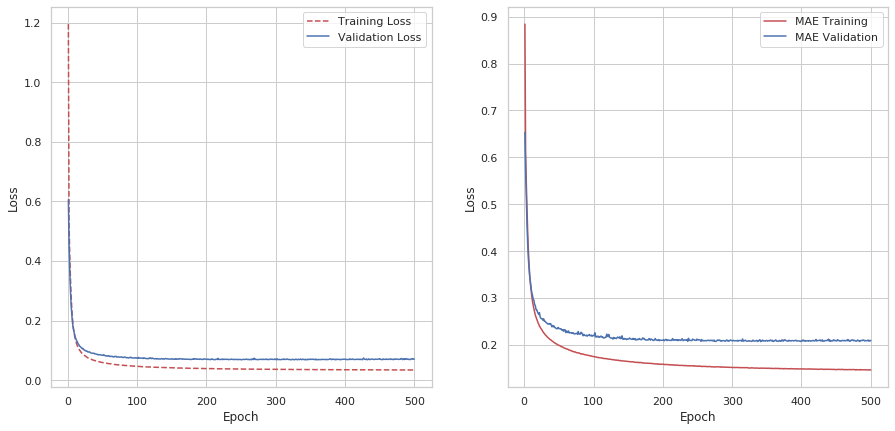

In [15]:
model = train_siamese(training_pairs=tr_pairs, 
              training_y=tr_y, 
              validation_pairs=val_pairs, 
              validation_y=val_y, 
              epochs=500, 
              batch_size=256, 
              learning_rate=0.0001,
              plot=True)

### (Or) Read model checkpoint

In [13]:
# stop here, change file

In [7]:
# #model_filename = "training/20191218_023743.h5"
model_filename = "training/20200221_061000.h5"

In [8]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

### Some model results

In [9]:
from cryoem.distance_estimation import plot_results

In [18]:
y_tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_val_pred = model.predict([val_pairs[:, 0], val_pairs[:, 1]])

In [19]:
plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

--- Train Set ---
predicted: 2.469917058944702
true:      2.625061511993408
mse:       0.024069800972938538
mae:       0.15514445304870605


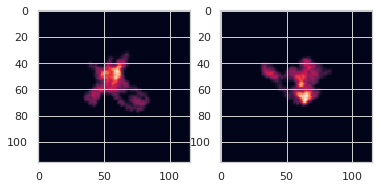

In [20]:
plot_train_results(1)

--- Validation Set ---
predicted: 2.221207618713379
true:      2.2472660541534424
mse:       0.0006790420738980174
mae:       0.026058435440063477


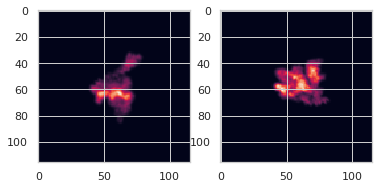

In [21]:
plot_validation_results(0)

---

## dP/dQ plot

In [22]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [23]:
def d_p(p1, p2):
    p1 = np.array(p1)
    p1 = p1.reshape(list(p1.shape) + [-1])
    p2 = np.array(p2)
    p2 = p2.reshape(list(p2.shape) + [-1])
    return model.predict([p1, p2])

In [24]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

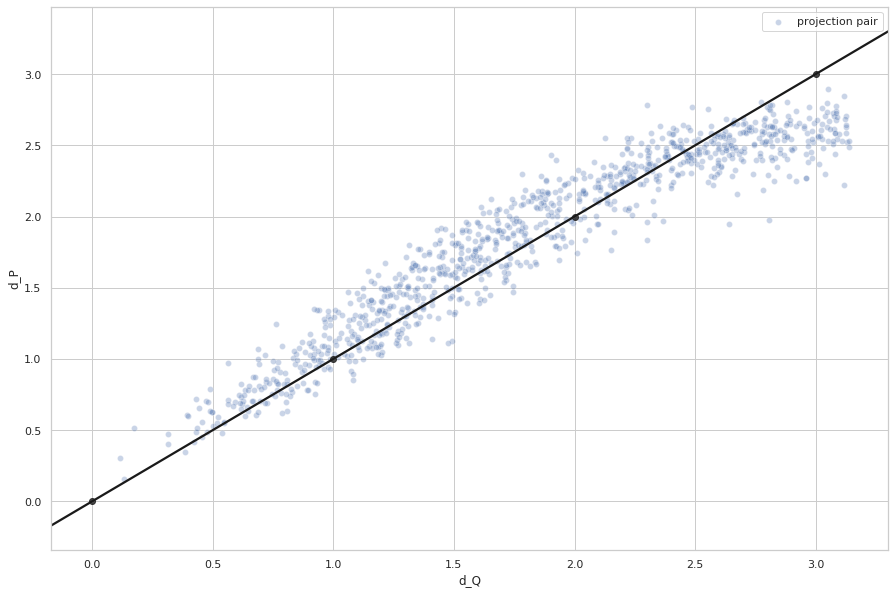

In [25]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

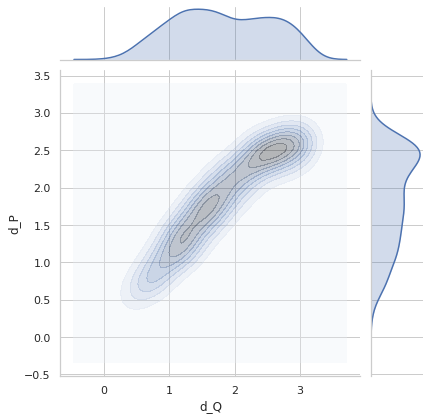

In [26]:
plot_dP_dQ_density(dP_values, dQ_values)

In [27]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.23167243011701683

# 2. Angle Recovery

In [28]:
from cryoem.angle_recovery import train_angle_recovery

In [29]:
num_pairs = 20000

###### Predicted Angles (initialization)

In [30]:
angle_shift = [0.0, 0.0, 0.0]
angle_coverage = [2.0, 0.4, 2.0]

low_ang = [x*np.pi for x in angle_shift]
high_ang = [x*np.pi for x in angle_coverage]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))

# angles_predicted = [tf.Variable(e, constraint=lambda x: mod_angles(x, angle_shift, angle_coverage)) for e in euler]
angles_predicted = [tf.Variable(e) for e in euler]


angles_predicted = np.array(angles_predicted)
angles_predicted.shape

(5000,)

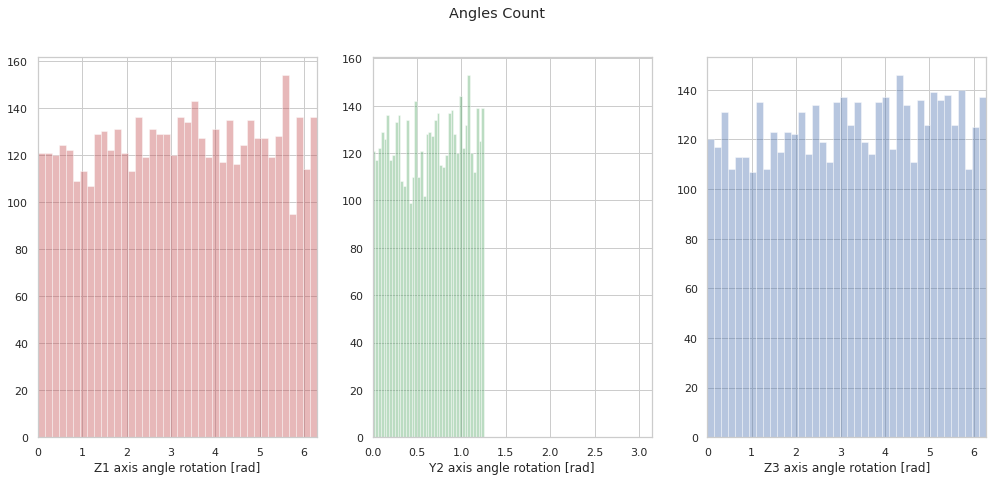

In [31]:
plot_angles_count(angles_predicted)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [32]:
from cryoem.angle_recovery import train_angle_recovery

In [ ]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=test_idx, 
                     angles_predicted=angles_predicted, 
                     est_dist_input=X, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

step 15000/150000 (5715s): loss = 8.96e-01
step 30000/150000 (11398s): loss = 8.41e-01
step 45000/150000 (17172s): loss = 7.28e-01
step 60000/150000 (22800s): loss = 8.07e-01


In [1]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_siamese1.npy", ang_save)

NameError: name 'np' is not defined

In [ ]:

#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles_siamese1.npy")

In [ ]:

plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [ ]:

filename = f"figures/{PROTEIN}_before_alignment_siamese1"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

In [ ]:

plot_rays(arr, num=100)

In [ ]:
filename = f"figures/{PROTEIN}_rays_siamese1"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

In [ ]:
# loss_predicted_vs_true_angle(steps=500, batch_size=256)

In [ ]:
# loss_predicted_angle_vs_projection(steps=15000, 
#                                    batch_size=512, 
#                                    optimization=True, 
#                                    angles_predicted=angles_predicted)

In [ ]:
# loss_predicted_vs_true_angle(steps=500, batch_size=256)

In [ ]:
# angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


# fig, axs = plt.subplots(1, 3, figsize=(17,7))
# axs[0].set_xlim(0,2*np.pi)
# axs[1].set_xlim(0,np.pi)
# axs[2].set_xlim(0,2*np.pi)
# plt.suptitle("Predicted Angles Count")

# sns.distplot(angles_predicted_plot[:,0], kde=False, bins=80, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
# sns.distplot(angles_predicted_plot[:,1], kde=False, bins=80, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
# sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [ ]:
# # plot
# all_vectors = RotationMatrix(angles_predicted_plot)
# ipv.figure(width=500, height=500)
# ipv.pylab.xlim(-1, 1)
# ipv.pylab.ylim(-1, 1)
# ipv.pylab.zlim(-1, 1)
# ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
# #ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
# ipv.show()

In [ ]:
# continue here

In [ ]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])
angles_true_plot = y

all_vectors_p = RotationMatrix(angles_predicted_plot)
all_vectors_t = RotationMatrix(angles_true_plot)

In [ ]:
limit=10

In [ ]:
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors_p[:limit,0], all_vectors_p[:limit,2], all_vectors_p[:limit,1], marker="sphere", color="green", size=1)

for i in range(limit):
    connection0 = [all_vectors_p[i,0], all_vectors_t[i,0]]
    connection1 = [all_vectors_p[i,1], all_vectors_t[i,1]]
    connection2 = [all_vectors_p[i,2], all_vectors_t[i,2]]
    ipv.plot(connection0, connection2, connection1, marker="sphere", color="red", size=1)
    
ipv.scatter(all_vectors_t[:limit,0], all_vectors_t[:limit,2], all_vectors_t[:limit,1], marker="sphere", color="red", size=1)

ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
ipv.show()

# 3. Angle Estimation Error

The ideal metric is the mean average angle estimation error, under best alignment:
$$
\min_R \frac{1}{n} \sum_{i=1}^n \left| d_Q(Q_i, R \hat{Q}_i) \right|
$$

* $d_Q$ is the distance between two quaternions
* $Q_i$ is the true quaternion (angles, rotation)
* $\hat{Q}_i$ is the estimated quaternion (angles, rotation)
* $R$ is a quaternion representing a global rotation which best aligns the two sets of quaternions

The estimated quaternions are globally rotated as $R \hat{Q}_i$, where the multiplication (the [Hamilton product](https://en.wikipedia.org/wiki/Quaternion#Hamilton_product)) of two quaternions is the composition of the two rotations they represent.

@Jelena: you can implement it with gradient descent, in the same way we
do angle recovery. To be sure, that is the third optimization in the
pipeline (after angle recovery), whose sole purpose is to evaluate the
recovery.

Once aligned (i.e., the best R is found), plot both the true and aligned
recovered (predicted) quaternions on the same sphere. Add dashed lines
that link each true angle with the recovered one. That should make a
great visualization.

You can compute the metric and plot the visualization on the two
recovered angles you showed today.

In [ ]:
angles_predicted_final = np.zeros((NUM_PROJECTIONS, 3))
for i, ap in enumerate(angles_predicted):
    angles_predicted_final[i] = ap.numpy()
    
np.save('data/angles_predicted_final.npy', angles_predicted_final)

---

In [ ]:
def lossR(a_R, a_predicted, a_true):
    a_predicted = list(a_predicted)
    a_true = list(a_true)
    
    q_predicted = euler2quaternion(a_predicted)
    q_true = euler2quaternion(a_true)
    q_R = euler2quaternion(a_R)

    distance = d_q(q_true, quaternion.multiply(q_R, q_predicted))
    
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(distance)

In [ ]:
def gradientR(a_R, a_predicted, a_true):
    with tf.GradientTape() as tape:
        loss_value = lossR(a_R, a_predicted, a_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient

In [ ]:
euler = np.zeros(3, dtype=np.float64)
a_R = [tf.Variable(euler)]

In [ ]:
print(f"rotation : {a_R[0].numpy()}\nloss     : {lossR(a_R, angles_predicted, y).numpy()}")

In [ ]:
loss_predicted_vs_true_angle(steps=500, batch_size=256)

In [ ]:
steps=20000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = Adam(learning_rate=0.01)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx = list(np.random.choice(NUM_PROJECTIONS, size=batch_size))
    
    # Compute distances between projections
    a_true = [y[i] for i in idx]
    a_predicted = [angles_predicted[i] for i in idx]
    
    # Optimize by gradient descent.
    losses[step-1], gradients = gradientR(a_R, a_predicted, a_true)
    optimizer.apply_gradients(zip(gradients, a_R))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

In [ ]:
print(f"rotation : {a_R[0].numpy()}\nloss     : {lossR(a_R, angles_predicted, y).numpy()}")

we have: 1.85 rad = 105 deg

we want: 10 deg = 0.17 rad

In [ ]:
# rotate to get new angles
q_predicted = euler2quaternion(angles_predicted)
q_R = euler2quaternion(a_R)
q_predicted_new = quaternion.multiply(q_predicted, q_R)

angles_predicted_new = quaternion2euler(q_predicted_new)

##### true vs. predicted vs.rotated prediction

In [ ]:
i = 0
y[i], angles_predicted[i].numpy(), angles_predicted_new[i].numpy()

In [ ]:
angles_predicted_plot_new = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted_new])
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])
angles_true_plot = y

all_vectors_p_new = RotationMatrix(angles_predicted_plot_new)
all_vectors_p = RotationMatrix(angles_predicted_plot)
all_vectors_t = RotationMatrix(angles_true_plot)

limit=10

# plot
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)

ipv.scatter(all_vectors_p[:limit,0], all_vectors_p[:limit,2], all_vectors_p[:limit,1], marker="sphere", color="blue", size=1)

for i in range(limit):
    connection0 = [all_vectors_p[i,0], all_vectors_p_new[i,0]]
    connection1 = [all_vectors_p[i,1], all_vectors_p_new[i,1]]
    connection2 = [all_vectors_p[i,2], all_vectors_p_new[i,2]]
    ipv.plot(connection0, connection2, connection1,color="green", lynestyle="--")

ipv.scatter(all_vectors_p_new[:limit,0], all_vectors_p_new[:limit,2], all_vectors_p_new[:limit,1], marker="sphere", color="green", size=1)

for i in range(limit):
    connection0 = [all_vectors_p_new[i,0], all_vectors_t[i,0]]
    connection1 = [all_vectors_p_new[i,1], all_vectors_t[i,1]]
    connection2 = [all_vectors_p_new[i,2], all_vectors_t[i,2]]
    ipv.plot(connection0, connection2, connection1, marker="sphere", color="red", size=1)

ipv.scatter(all_vectors_t[:limit,0], all_vectors_t[:limit,2], all_vectors_t[:limit,1], marker="sphere", color="red", size=1)

ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
ipv.show()


In [ ]:
loss_predicted_vs_true_angle(steps=500, batch_size=256, angles_predicted=angles_predicted_new)